#### Team Name : A-Team
#### Team Members : Ponmanikandan Velmurugan (862206551), Arun Venkatesh(862247205)
#### Title : Crytocurrency Prediction - Linear Regression

In [1]:
#Importing Public Libraries
import os
import math
import time
import json
import datetime
import numpy as np
import pandas as pd
from calendar import monthrange
import matplotlib.pyplot as plt
import import_ipynb #Import for accessing other ipynb notebooks

In [2]:
#Importing Private Libraries
from Utils import APIConnector
from DatasetHandler import DatasetHandler

importing Jupyter notebook from Utils.ipynb
importing Jupyter notebook from DatasetHandler.ipynb


In [3]:
#Defining Global Variables
path = os.getcwd()
month_names = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

In [4]:
# Fetches the historic missing data rows for a given timestamp
def getAPIJSON(timestamp, cryptoType): 
    apiConnector = APIConnector()
    resp = apiConnector.invokeAPI(APIConnector.dayPriceUrl, [cryptoType[:3], "USD",str(timestamp)])
    data_json = json.loads(resp.text)["Data"][0]
    return data_json["high"], data_json["low"], data_json["open"], data_json["close"] 

In [5]:
# Cleaner and Integrator Method
# Handles Data Processing - Generates dataframe based on cryptotype (ETH, BTC)
# Handles Data Integration - Fills missing values using the above method
def genrateShortDataFrame(dataframe, input_years, currency) : 
    curriencies = []; days = []; months = []; years = []; highs = []; lows = []; opens = []; closes = []
    for year in input_years : 
        for month in range(1, 13) : 
            max_date = monthrange(year, month)[1]        
            for date in range(1, max_date + 1) : 
                current_df = dataframe[(dataframe['Day'] == date) & (dataframe['Month'] == month) & (dataframe['Year'] == year) & (dataframe['Symbol'] == currency)]
                curriencies.append(currency); days.append(date); months.append(month); years.append(year);
                if len(current_df[(current_df['Hour'] == 0) & (current_df['Minute'] == 0)]['Open'].values) == 0  or len(current_df[(current_df['Hour'] == 23) & (current_df['Minute'] == 59)]['Close']) == 0 :  
                    date_string = str(date) + "/" + str(month) + "/" + str(year)
                    timestamp = time.mktime(datetime.datetime.strptime(date_string, "%d/%m/%Y").timetuple())
                    high_record, low_record, open_record, close_record = getAPIJSON(timestamp, currency)
                    highs.append(high_record); lows.append(low_record); opens.append(open_record); closes.append(close_record)
                else : 
                    highs.append(current_df['High'].max())
                    lows.append(current_df['Low'].min())
                    opens.append(current_df[(current_df['Hour'] == 0) & (current_df['Minute'] == 0)]['Open'].values[0])
                    closes.append(current_df[(current_df['Hour'] == 23) & (current_df['Minute'] == 59)]['Close'].values[0])
                    
    df_short = pd.DataFrame(data = {'Symbol' : currency, 'Day' : days, 'Month' : months, 'Year' : years, 'Open' : opens,  'Close' : closes, 'Low' : lows, 'High' : highs})
    return df_short

In [6]:
# Fetching training dataframe(s) for both ETH and BTC
tm = DatasetHandler([path + '/datasets/historic/eth_2018.csv', path + '/datasets/historic/eth_2019.csv', path + '/datasets/historic/btc_2018.csv', path + '/datasets/historic/btc_2019.csv'])
tm.readFiles()
df_train = tm.mergeDataFrames()

['/home/csgrads/pvelm001/Project/datasets/historic/eth_2018.csv', '/home/csgrads/pvelm001/Project/datasets/historic/eth_2019.csv', '/home/csgrads/pvelm001/Project/datasets/historic/btc_2018.csv', '/home/csgrads/pvelm001/Project/datasets/historic/btc_2019.csv']


In [7]:
df_train

,Unix Timestamp,Symbol,Open,High,Low,Close,Volume,Day,Month,Year,Hour,Minute
0,1546300740000,ETHUSD,130.00,130.80,130.00,130.80,8.688215,31,12,2018,23,59
1,1546300680000,ETHUSD,130.00,130.00,130.00,130.00,7.966173,31,12,2018,23,58
2,1546300620000,ETHUSD,130.00,130.00,128.53,130.00,44.386537,31,12,2018,23,57
3,1546300560000,ETHUSD,130.80,130.80,130.00,130.00,79.267075,31,12,2018,23,56
4,1546300500000,ETHUSD,130.80,130.80,130.80,130.80,0.000000,31,12,2018,23,55
...,...,...,...,...,...,...,...,...,...,...,...,...
496766,1546301040000,BTCUSD,3691.21,3691.21,3691.21,3691.21,0.000000,1,1,2019,0,4
496767,1546300980000,BTCUSD,3689.50,3691.21,3689.50,3691.21,1.030911,1,1,2019,0,3
496768,1546300920000,BTCUSD,3689.67,3689.67,3689.50,3689.50,0.001103,1,1,2019,0,2
496769,1546300860000,BTCUSD,3695.00,3695.00,3689.67,3689.67,0.004174,1,1,2019,0,1


In [8]:
# Fetching only ETH
df_train_ETH = genrateShortDataFrame(df_train, [2018, 2019], "ETHUSD")
df_train_ETH["Variability"] = df_train_ETH["Close"] - df_train_ETH["Open"]
df_train_ETH #Take time to filter (~2 mins)

,Symbol,Day,Month,Year,Open,Close,Low,High,Variability
0,ETHUSD,1,1,2018,736.11,750.77,719.00,760.00,14.66
1,ETHUSD,2,1,2018,750.77,859.98,750.77,877.00,109.21
2,ETHUSD,3,1,2018,859.98,940.00,847.65,950.00,80.02
3,ETHUSD,4,1,2018,940.00,947.88,905.00,999.00,7.88
4,ETHUSD,5,1,2018,947.88,968.33,931.40,1020.00,20.45
...,...,...,...,...,...,...,...,...,...
725,ETHUSD,27,12,2019,125.32,126.13,122.20,126.59,0.81
726,ETHUSD,28,12,2019,126.13,127.83,125.86,129.50,1.70
727,ETHUSD,29,12,2019,127.83,134.21,126.96,137.53,6.38
728,ETHUSD,30,12,2019,134.21,131.00,130.00,135.77,-3.21


In [9]:
# Generates only BTC
df_train_BTC = genrateShortDataFrame(df_train, [2018, 2019], "BTCUSD")
df_train_BTC["Variability"] = df_train_BTC["Close"] - df_train_BTC["Open"]
df_train_BTC #Take time to filter (~2 mins)

,Symbol,Day,Month,Year,Open,Close,Low,High,Variability
0,BTCUSD,1,1,2018,13820.26,13338.41,12800.00,13824.23,-481.85
1,BTCUSD,2,1,2018,13338.41,14740.09,12851.00,15249.97,1401.68
2,BTCUSD,3,1,2018,14740.09,15144.00,14583.47,15400.00,403.91
3,BTCUSD,4,1,2018,15144.00,15199.99,14000.00,15503.59,55.99
4,BTCUSD,5,1,2018,15199.99,16945.50,14800.00,17124.44,1745.51
...,...,...,...,...,...,...,...,...,...
725,BTCUSD,27,12,2019,7195.83,7241.66,7062.39,7253.38,45.83
726,BTCUSD,28,12,2019,7241.66,7300.70,7238.90,7349.24,59.04
727,BTCUSD,29,12,2019,7300.70,7390.42,7276.40,7521.92,89.72
728,BTCUSD,30,12,2019,7390.42,7216.27,7199.97,7390.42,-174.15


### Plotting Functions :

In [36]:
#Plots feature distribution
def Plot_Growth(target_df, title, ylabel, kind = 'line', xlabel = 'Days', figsize = (20, 10)) : 
    ax = target_df.plot(kind = kind,
                        grid = True,
                        legend = True,
                        figsize = figsize,
                        title = title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

In [11]:
#Generates Variability based on month
def getMonthVariability(dataframe) : 
    labels = []
    month_variability = []
    for i in range(1, 13) : 
        labels.append(str(i) + " - 2018")
        current_df = dataframe[(dataframe["Month"] == i) & (dataframe["Year"] == 2018)]
        month_variability.append(current_df['Close'].iloc[-1] - current_df['Open'].iloc[0])
    for i in range(1, 13) : 
        labels.append(str(i) + " - 2019")
        current_df = dataframe[(dataframe["Month"] == i) & (dataframe["Year"] == 2019)]
        month_variability.append(current_df['Close'].iloc[-1] - current_df['Open'].iloc[0])
    return pd.DataFrame(data = { "Variability" : month_variability })

In [32]:
#Month based comparison across years
def Month_Plot(dataframe, month, target, axis = None, figsize = (10, 10)) : 
    target_df = pd.DataFrame()
    for year in [2018, 2019] : 
        target_df[str(month) + " - " + str(year)] = dataframe[(dataframe['Month'] == month) & (dataframe['Year'] == year)][target].reset_index(drop = True)
    ax = target_df.plot(kind = 'line',
                    ax = axis,
                    grid = True,
                    legend = True,
                    figsize = figsize,
                    title = month_names[month - 1] + ' 2018 vs ' + month_names[month - 1] + ' 2019')
    ax.set_xlabel("Days")
    ax.set_ylabel(target)

In [33]:
#Month based multiplot
def Month_Multi_Plot(dataframe, target) :
    month = 1
    figure, axis = plt.subplots(4, 3)
    plt.subplots_adjust(hspace = 0.5, wspace= 0.5)

    for i in range(4) :
        for j in range (3) :
            Month_Plot(dataframe, month, target, axis[i, j], figsize = (20, 20))
            month = month + 1

## Comparisons of Cryptocurrencies : ETH vs BTC

#### 2018 - 2019 Daily Data Analysis : 

We are going to perform analysis on ETH and BTC for the time period 2018 - 2019

Downfall of Crypto Study: https://en.wikipedia.org/wiki/Cryptocurrency_bubble

We can Infer from that there is a steep downslide of the Ethereum price. This is due to multitude of factors the important one is the hacking of  Coincheck, Japan's largest cryptocurrency OTC market market that took place in January 2018. We can also infer the drop/gain in price with further analysis:

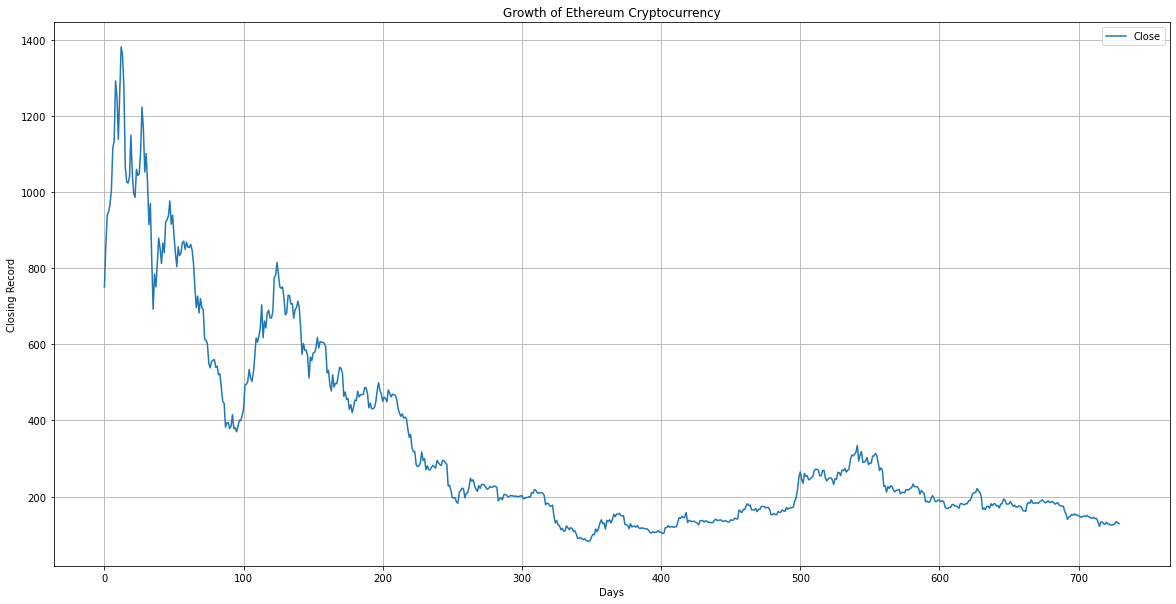

In [37]:
title = "Growth of Ethereum Cryptocurrency"
Plot_Growth(df_train_ETH['Close'], title, 'Closing Record')

#### Observations:

1. We can see that the closing value is very high during the start of 2018, but slowly drops down as each day passes.
2. After researching through the above mentioned crypto study, we can easily relate this downfall to the hacking event.
3. The highest closing value for ETH in 2018-2019 was around USD 1390 whereas the lowest closing value was USD 150, which is a **89% drop** over the year 2018.

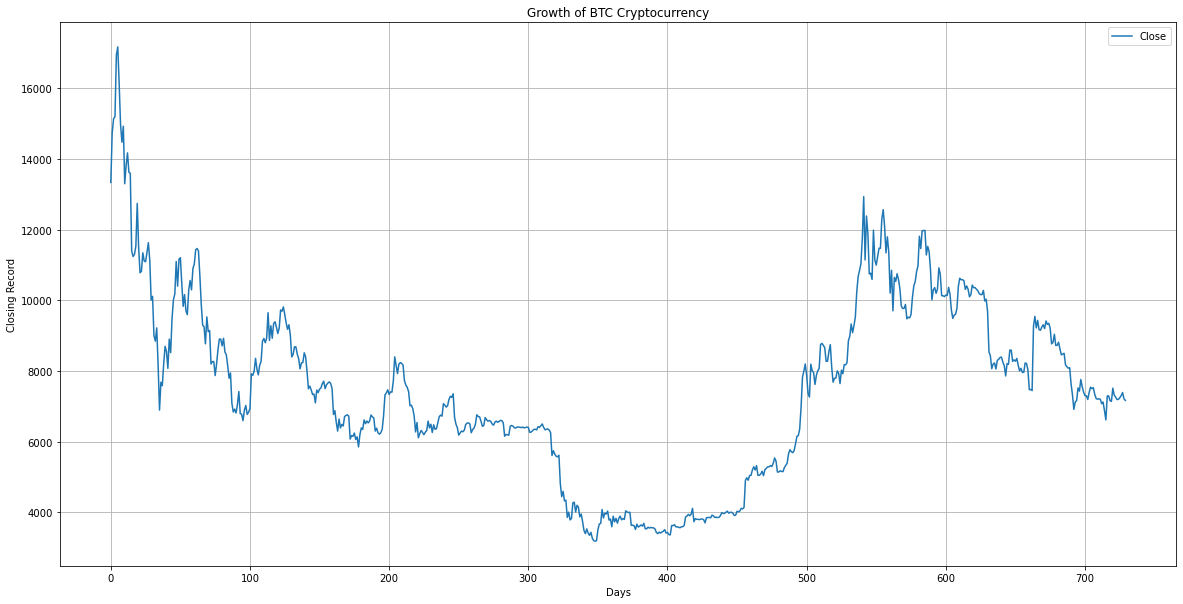

In [38]:
title = "Growth of BTC Cryptocurrency"
Plot_Growth(df_train_BTC['Close'], title, 'Closing Record')

#### Observations:

1. We can see that the closing value is very high during the start of 2018, but slowly drops down as each day passes.
2. We can also see that in the end of 2018 and just before the start of 2019, the value of BTC drops to the lowest and the drop rate is **82.3%**.
3. This can also be related to the downfall to the hacking event.
4. The highest closing value for BTC in 2018-2019 was around USD 17000 whereas the lowest closing value was USD 3700.

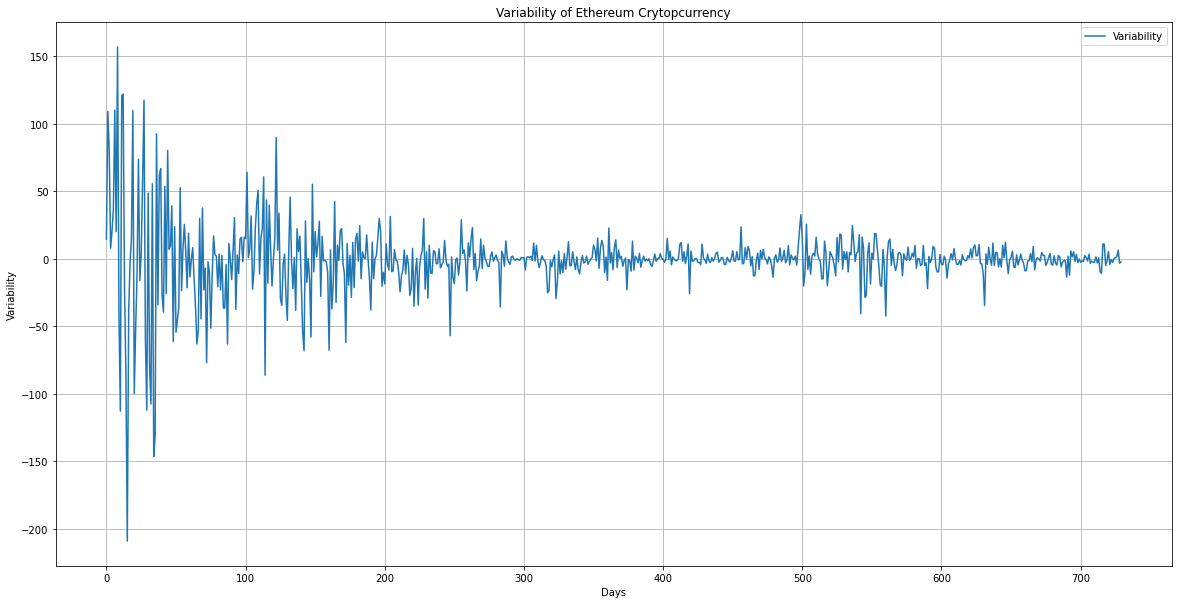

In [40]:
title = "Variability of Ethereum Crytopcurrency"
Plot_Growth(df_train_ETH["Variability"], title, "Variability")

#### Observations:

1. We can see that the variability of ETH for 2018 is very high in the starting stages, which might be due to lot of investors or even new investors who invested big in ETH.
2. As days went by, the value slowly became stagnant and reaching close to 0 or very close to it comparing it with its highest value USD 152.
3. The highest variable for ETH in 2018-2019 was around USD 152 whereas the lowest variable value was -USD 220 and both were in the month of January 2018.

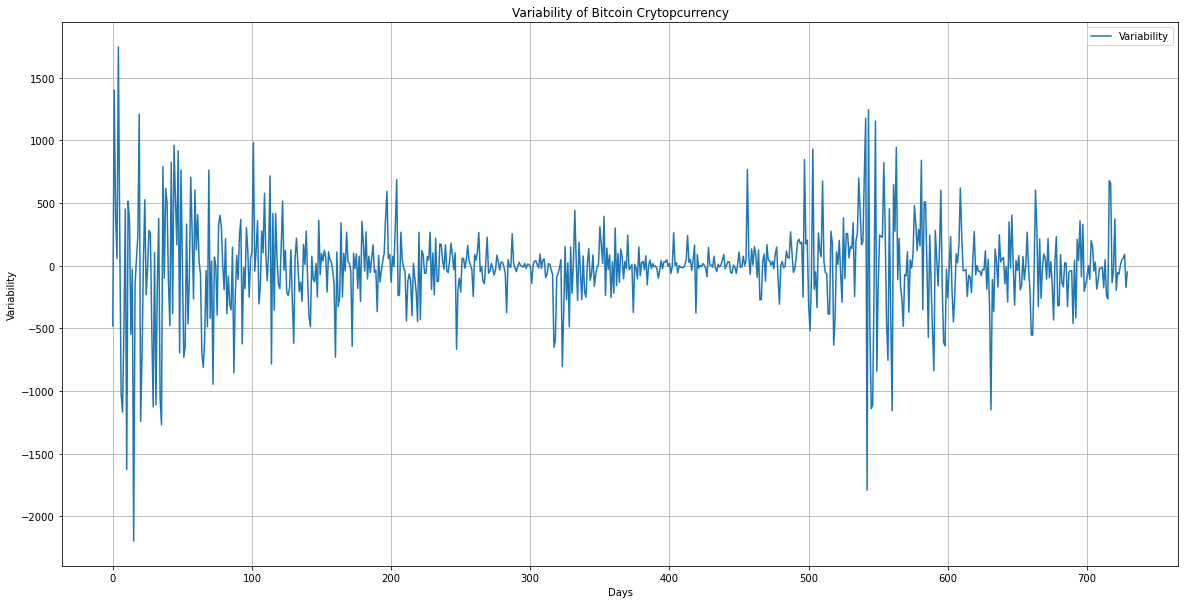

In [41]:
title = "Variability of Bitcoin Crytopcurrency"
Plot_Growth(df_train_BTC["Variability"], title, "Variability")

#### Observations:

1. We can see that the variability of BTC for 2018 is very high in the starting stages, whereas in 2019, the spike was in the middle of the year.
2. This might be due to the result of safe play by the investors, who should have seen the low variablity until the end of previous year.
3. The highest variable for BTC in 2018-2019 was around USD 1600 whereas the lowest variable value was -USD 2200 and both were in the month of January 2018.

#### 2018 - 2019 Monthly Analysis : 

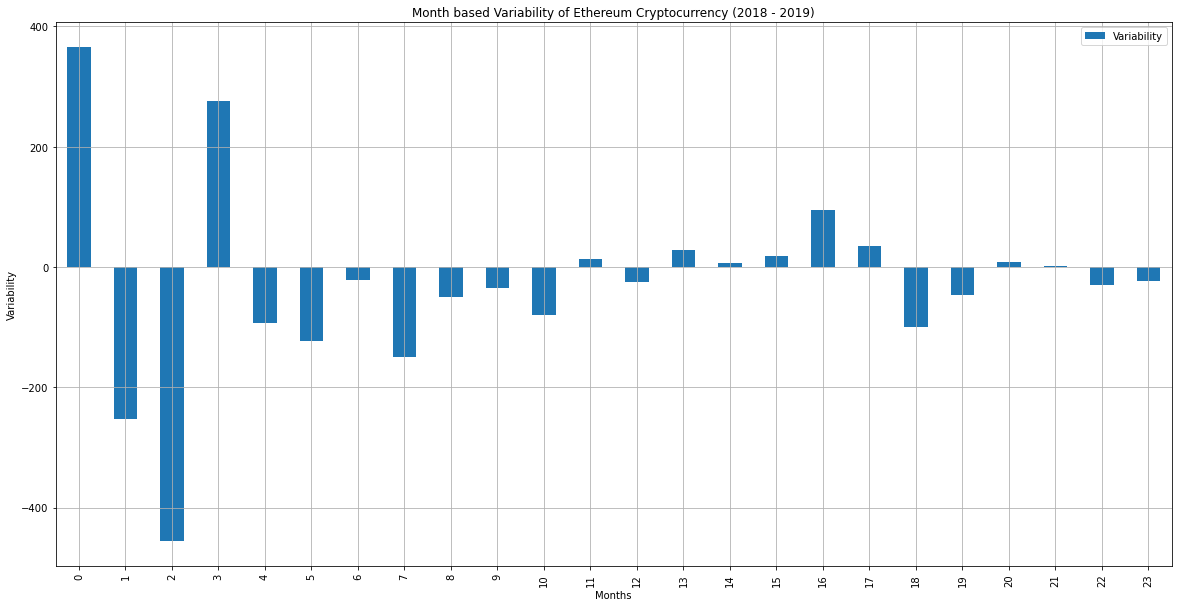

In [42]:
title = "Month based Variability of Ethereum Cryptocurrency (2018 - 2019)"
Plot_Growth(getMonthVariability(df_train_ETH), title, 'Variability', kind = 'bar', xlabel = "Months")

#### Observations:

1. We can see that the monthly variability of ETH for 2018 is very high in the month of March, whereas in 2019, there was no noticeable spike compared to the previous years.
2. No matter how many spikes ETH had on a day-to-day basis, the monthly variability did not change much.
3. The highest monthly variable for ETH in 2018-2019 was around USD 380 whereas the lowest variable value was -USD 420 and both were in 2018.

From the above graph we can infer that there was a great to-fro changes in the early months of 2018. Later than that, the variability is minimal or stabilized after September 2018

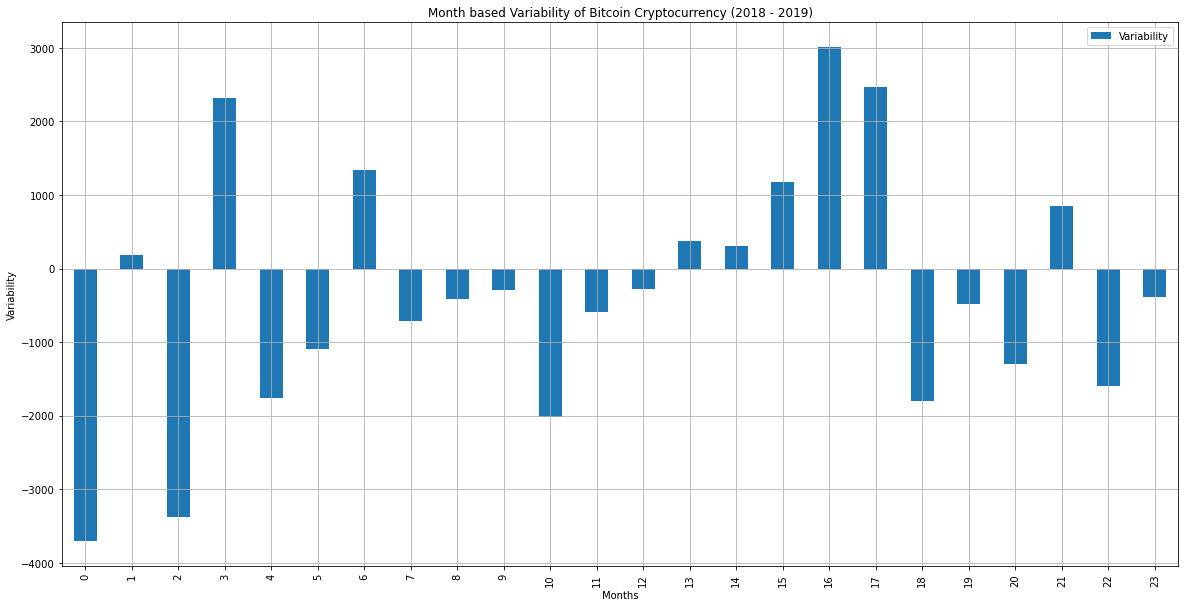

In [43]:
title = "Month based Variability of Bitcoin Cryptocurrency (2018 - 2019)"
Plot_Growth(getMonthVariability(df_train_BTC), title, 'Variability', kind = 'bar',  xlabel = "Months")

#### Observations:

1. We can see that the monthly variability of BTC for 2018-2019 had a lot of negative spikes than the positive spikes
2. The highest monthly variable for BTC in 2018-2019 was around USD 3000 in March 2019 whereas the lowest variable value was -USD 3800 in January 2018.

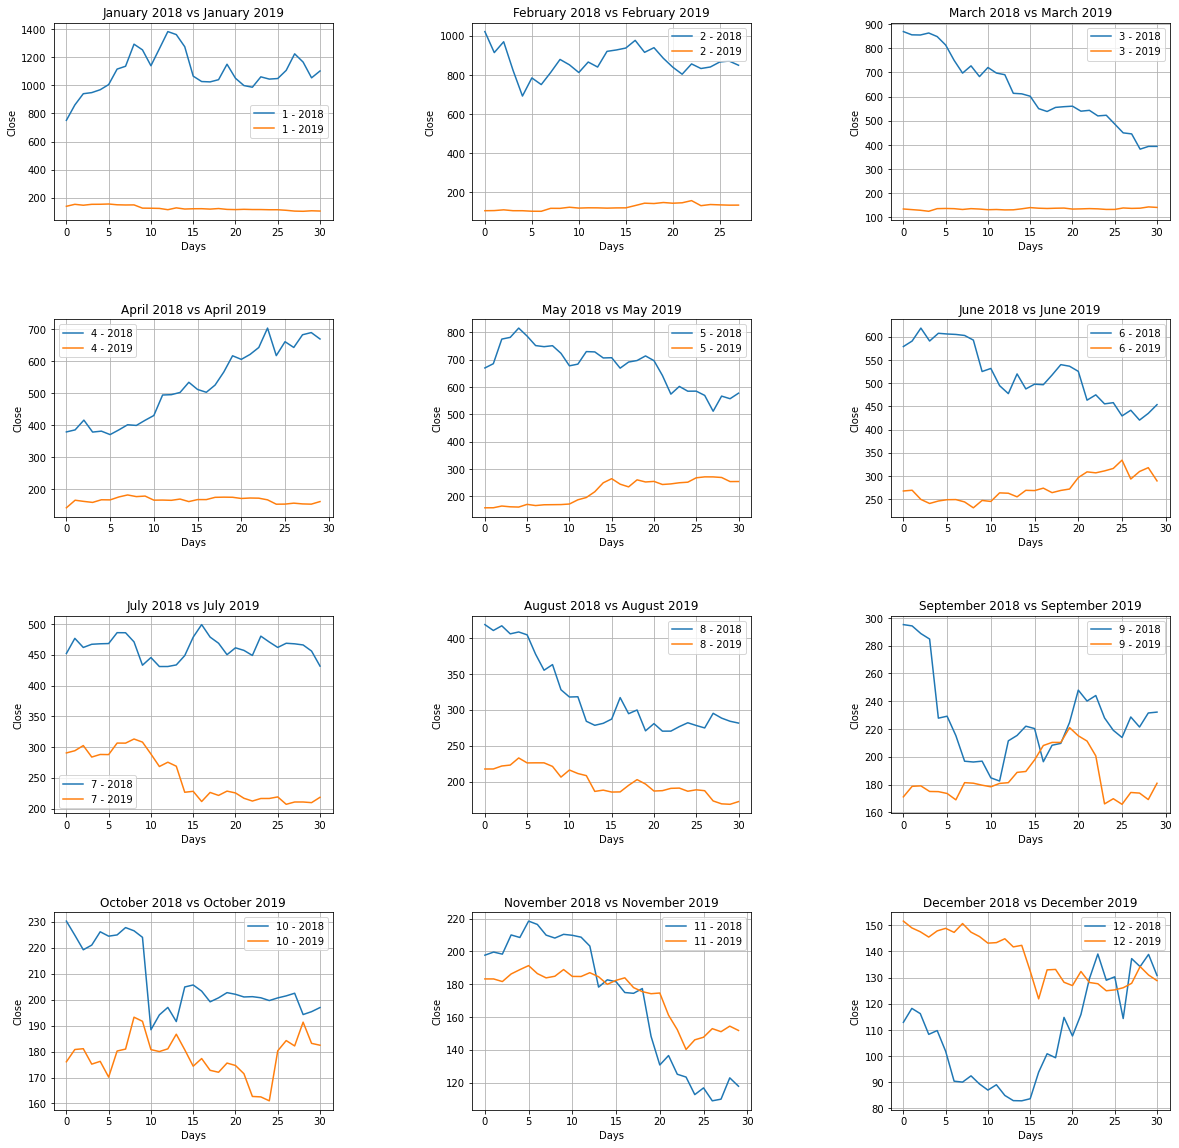

In [24]:
Month_Multi_Plot(df_train_ETH, 'Close')

#### Observations:

1. We can see that the close value comparison of months across 2018-2019 for ETH was more in the year 2018 compared to 2019.

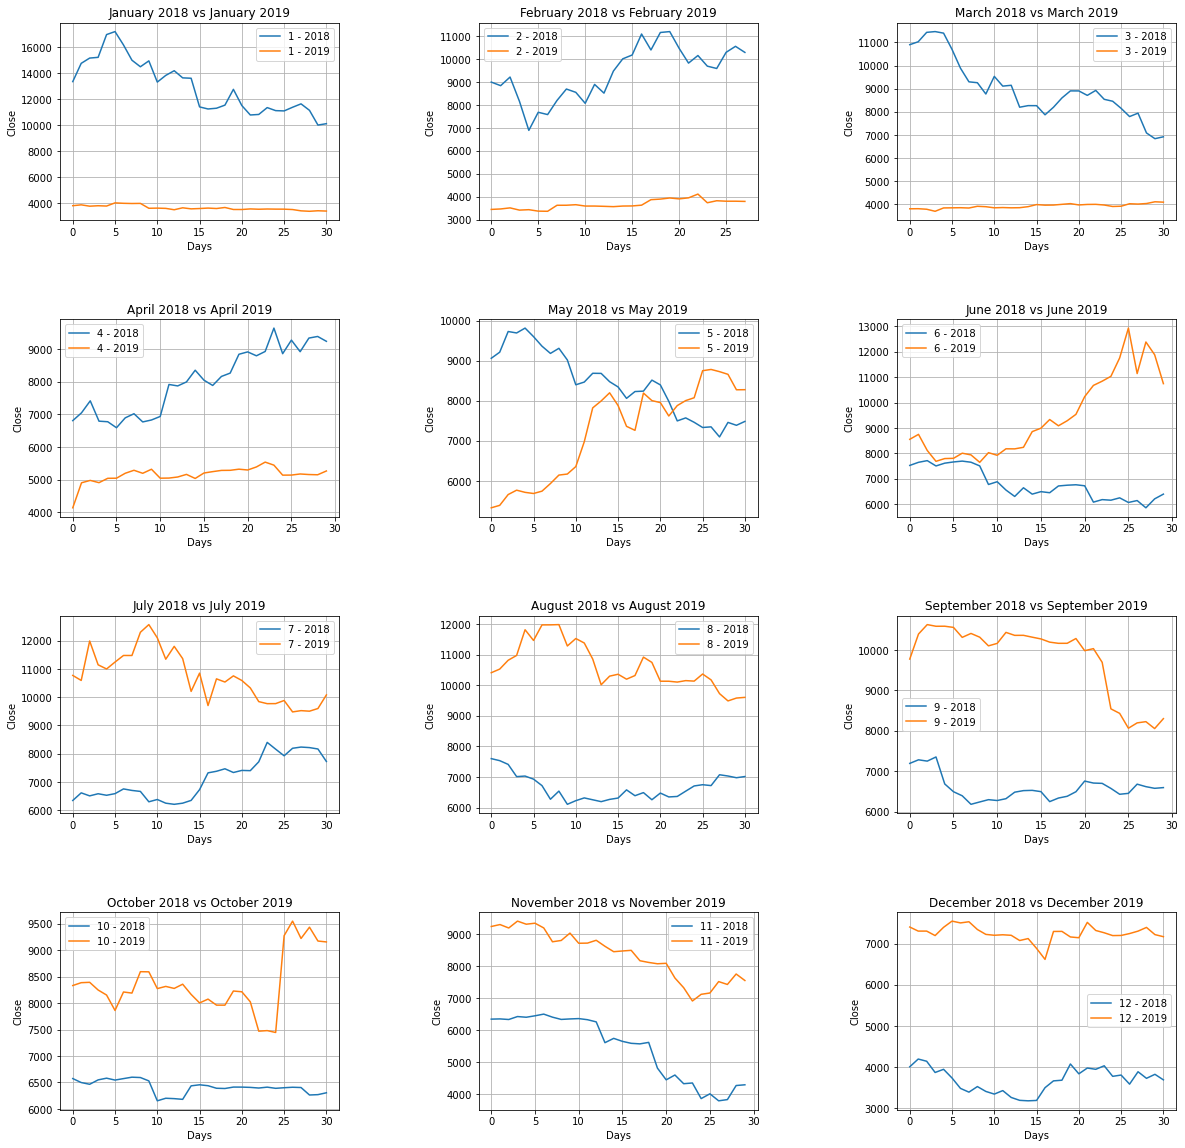

In [25]:
Month_Multi_Plot(df_train_BTC, 'Close')

#### Observations:

1. We can see that the close value comparison of months across 2018-2019 for BTC was more in the year 2019 compared to 2018.
2. There is an interesting over take in the year 2019 over 2018 from the month of May.

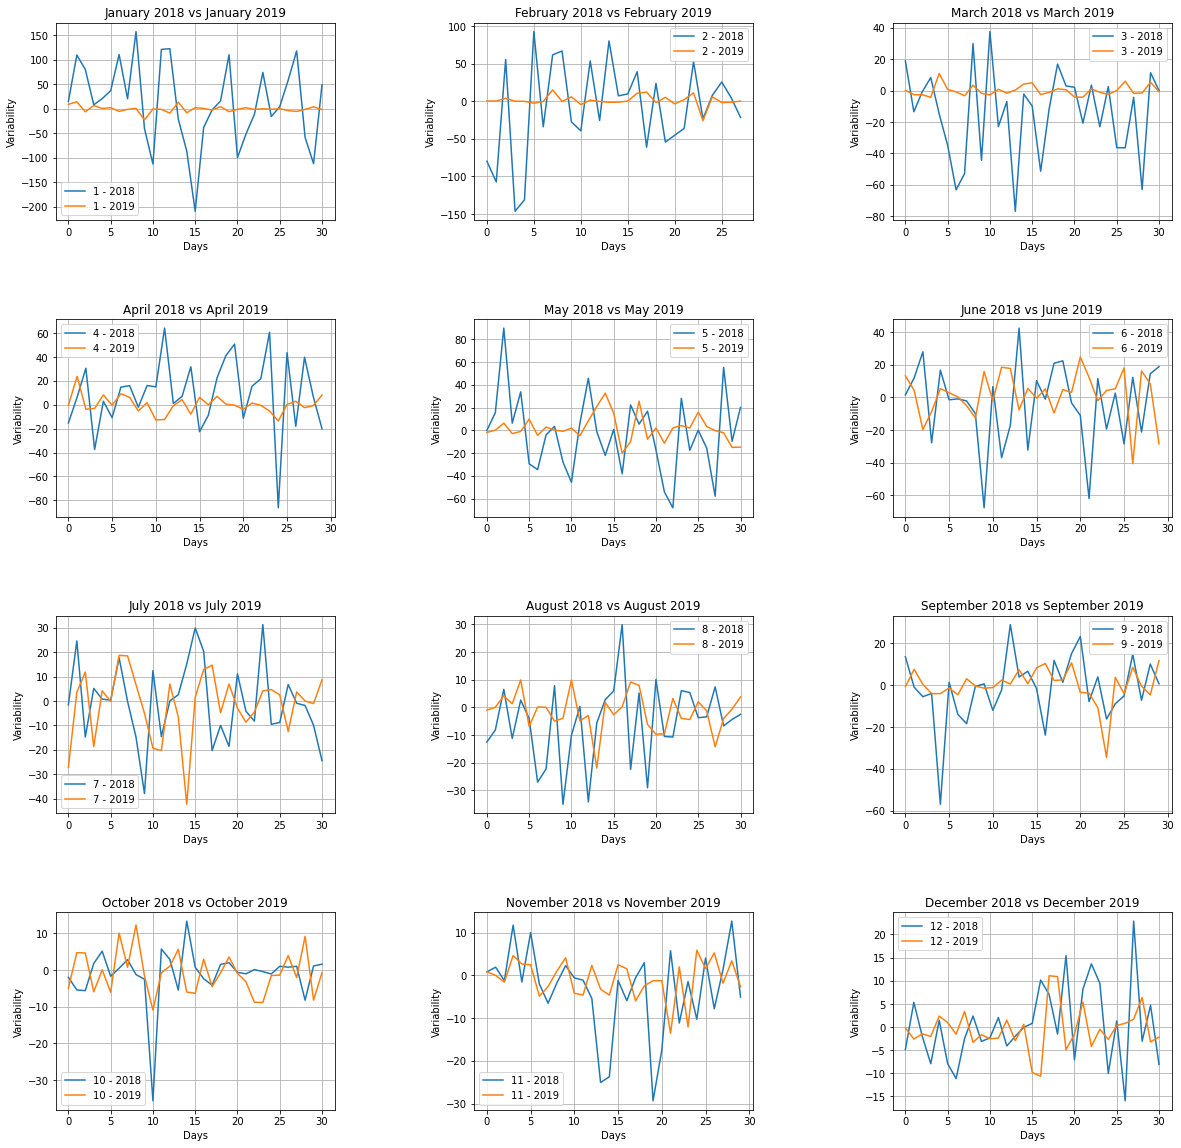

In [26]:
Month_Multi_Plot(df_train_ETH, 'Variability')

#### Observations

1. The variability of each day for both 2018 and 2019 seem to correlate from the month of May for ETH.
2. The interesting thing here is if the pattern keeps up, we can predict of closing values with the previous year's variability.

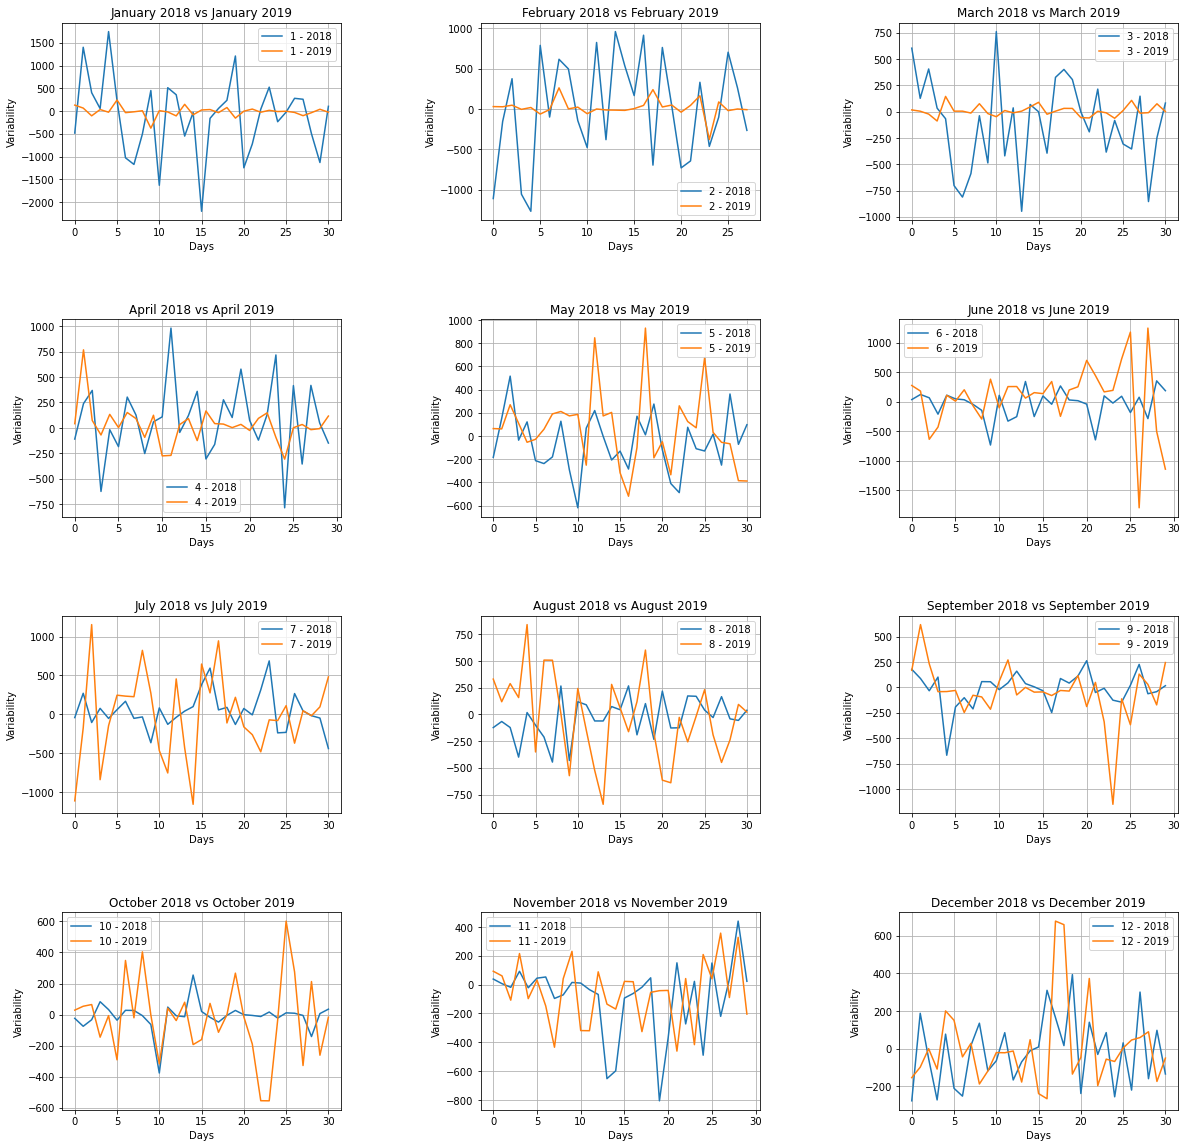

In [27]:
Month_Multi_Plot(df_train_BTC, 'Variability')

#### Observations

1. The variability of each day for both 2018 and 2019 seem to correlate from the month of April for BTC.
2. The interesting thing here is if the pattern keeps up, we can predict of closing values with the previous year's variability.

## Regression Model Creation : 

In [44]:
# Fetching testing dataframe(s) for both ETH and BTC
tm = DatasetHandler([path + '/datasets/historic/eth_2020.csv', path + '/datasets/historic/btc_2020.csv'])
tm.readFiles()
df_test = tm.mergeDataFrames()

['/home/csgrads/pvelm001/Project/datasets/historic/eth_2020.csv', '/home/csgrads/pvelm001/Project/datasets/historic/btc_2020.csv']


In [45]:
df_test

,Unix Timestamp,Symbol,Open,High,Low,Close,Volume,Day,Month,Year,Hour,Minute
0,1609459140000,ETHUSD,738.00,738.03,737.39,737.39,0.997336,31,12,2020,23,59
1,1609459080000,ETHUSD,738.66,738.66,738.00,738.00,1.190000,31,12,2020,23,58
2,1609459020000,ETHUSD,738.13,738.66,738.13,738.66,12.519947,31,12,2020,23,57
3,1609458960000,ETHUSD,738.48,738.48,738.13,738.13,1.312525,31,12,2020,23,56
4,1609458900000,ETHUSD,738.87,738.87,738.48,738.48,0.204095,31,12,2020,23,55
...,...,...,...,...,...,...,...,...,...,...,...,...
501128,1577837040000,BTCUSD,7163.60,7163.60,7163.00,7163.00,1.751844,1,1,2020,0,4
501129,1577836980000,BTCUSD,7163.00,7163.60,7163.00,7163.60,0.002706,1,1,2020,0,3
501130,1577836920000,BTCUSD,7163.30,7164.22,7163.00,7163.00,0.063904,1,1,2020,0,2
501131,1577836860000,BTCUSD,7163.30,7164.23,7163.30,7163.30,0.002646,1,1,2020,0,1


In [46]:
# Fetching only ETH
df_test_ETH = genrateShortDataFrame(df_test, [2020], "ETHUSD")
df_test_ETH #Take time to filter (~2 mins)

,Symbol,Day,Month,Year,Open,Close,Low,High
0,ETHUSD,1,1,2020,128.84,130.25,128.07,132.57
1,ETHUSD,2,1,2020,130.25,126.83,126.19,130.25
2,ETHUSD,3,1,2020,126.83,133.94,125.60,134.62
3,ETHUSD,4,1,2020,133.94,134.14,132.58,136.00
4,ETHUSD,5,1,2020,134.14,135.39,134.10,138.16
...,...,...,...,...,...,...,...,...
361,ETHUSD,27,12,2020,636.70,683.86,616.03,715.43
362,ETHUSD,28,12,2020,683.86,729.58,681.12,747.26
363,ETHUSD,29,12,2020,729.58,731.39,688.05,739.09
364,ETHUSD,30,12,2020,731.39,752.31,716.32,759.00


In [47]:
# Generates only BTC
df_test_BTC = genrateShortDataFrame(df_test, [2020], "BTCUSD")
df_test_BTC #Take time to filter (~2 mins)

,Symbol,Day,Month,Year,Open,Close,Low,High
0,BTCUSD,1,1,2020,7165.90,7175.20,7146.60,7231.65
1,BTCUSD,2,1,2020,7175.20,6944.90,6901.02,7186.65
2,BTCUSD,3,1,2020,6944.90,7333.00,6860.00,7398.00
3,BTCUSD,4,1,2020,7333.00,7352.82,7258.53,7394.40
4,BTCUSD,5,1,2020,7352.82,7351.77,7313.53,7490.17
...,...,...,...,...,...,...,...,...
361,BTCUSD,27,12,2020,26453.06,26266.84,25792.41,28395.00
362,BTCUSD,28,12,2020,26266.84,27044.13,26088.00,27487.23
363,BTCUSD,29,12,2020,27044.13,27368.90,25847.00,27400.00
364,BTCUSD,30,12,2020,27368.90,28898.55,27342.74,28998.00


In [50]:
#Doing cross-validation for ETH
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor


selected_columns = ['Day', 'Month', 'Year', 'Open']

X_train = df_train_ETH[selected_columns]
y_train = df_train_ETH['Close']

linear_regression_pipeline = make_pipeline( #In different scales
    StandardScaler(),
    LinearRegression()
) 

scores = cross_val_score (estimator = linear_regression_pipeline, 
                          X = X_train, 
                          y = y_train,
                          cv = 10)

#print("Chosen Features : ", X_train.columns.tolist())
print("ETH Cross Validation Accuracy : ", np.mean(scores))

ETH Cross Validation Accuracy :  0.8392206783109616


In [51]:
#Doing cross-validation for BTC
selected_columns = ['Day', 'Month', 'Year', 'Open']

X_train = df_train_BTC[selected_columns]
y_train = df_train_BTC['Close']

linear_regression_pipeline = make_pipeline( #In different scales
    StandardScaler(),
    LinearRegression()
) 

scores = cross_val_score (estimator = linear_regression_pipeline, 
                          X = X_train, 
                          y = y_train,
                          cv = 10)

#print("Chosen Features : ", X_train.columns.tolist())
print("BTC Cross Validation Accuracy : ", np.mean(scores))

BTC Cross Validation Accuracy :  0.7814799945355081


In [53]:
#Predicting the test values
selected_columns = ['Day', 'Month', 'Year', 'Open']

X_train = df_train_ETH[selected_columns]
y_train = df_train_ETH['Close']

X_test = df_test_ETH[selected_columns]
y_test = df_test_ETH['Close']

X_train_scaler = StandardScaler()
X_train_scaled = X_train_scaler.fit_transform(X_train)

X_test_scaler = StandardScaler()
X_test_scaled = X_test_scaler.fit_transform(X_test)

eth_model = LinearRegression()
eth_model.fit(X = X_train_scaled, y = y_train)
y_pred = eth_model.predict(X = X_test_scaled)

In [54]:
eth_model.coef_

array([ -0.73155147,  -2.09212013,  -1.0322268 , 257.39423781])

#### Observations

1. Among all the selecteed features, the model is sensitive to "open" feature than any other features considered.

In [55]:
from sklearn.metrics import mean_absolute_error
print("ETH Mean Absolute Error ",mean_absolute_error(y_test, y_pred))
print("ETH Mean squared error: %.2f" % np.mean((eth_model.predict(X_test_scaled) - y_test) ** 2))
print('ETH Variance score: %.2f' % eth_model.score(X_test_scaled, y_test))

ETH Mean Absolute Error  91.45911706540323
ETH Mean squared error: 13363.18
ETH Variance score: 0.36


Text(0, 0.5, 'Closing Record')

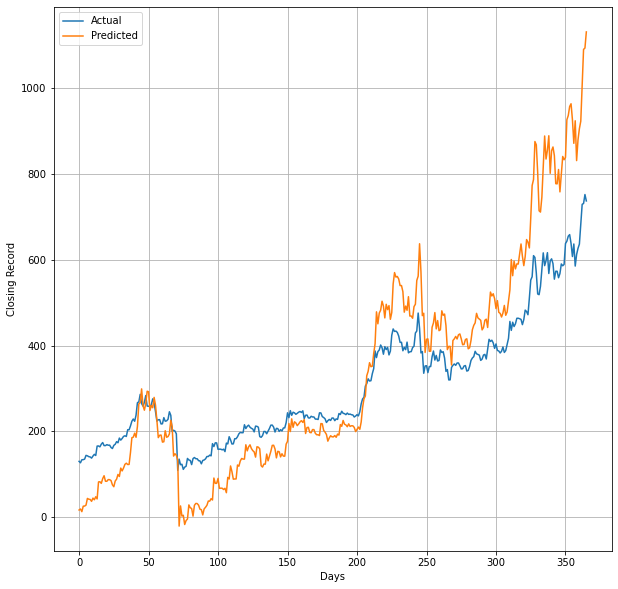

In [57]:
target_df = pd.DataFrame()
target_df["Actual"] = df_test_ETH['Close']
target_df["Predicted"] = y_pred

ax = target_df.plot(kind = 'line',
                grid = True,
                legend = True,
                figsize = (10, 10),
                title = "ETH : Predicted VS Actual - Linear Regression")
ax.set_xlabel("Days")
ax.set_ylabel("Closing Record")

In [60]:
#Predicting the test values
selected_columns = ['Day', 'Month', 'Year', 'Open']

X_train = df_train_BTC[selected_columns]
y_train = df_train_BTC['Close']

X_test = df_test_BTC[selected_columns]
y_test = df_test_BTC['Close']

X_train_scaler = StandardScaler()
X_train_scaled = X_train_scaler.fit_transform(X_train)

X_test_scaler = StandardScaler()
X_test_scaled = X_test_scaler.fit_transform(X_test)

btc_model = LinearRegression()
btc_model.fit(X = X_train_scaled, y = y_train)
y_pred = btc_model.predict(X = X_test_scaled)

In [61]:
btc_model.coef_

array([ -12.42077048,   -5.8556038 ,   14.54517046, 2512.3561732 ])

#### Observations

1. Among all the selecteed features, the model is sensitive to "open" feature than any other features considered.
2. We can also see that the model trained itself to the BTC scale. (Larger than ETH)

In [64]:
from sklearn.metrics import mean_absolute_error
print("BTC Mean Absolute Error ",mean_absolute_error(y_test, y_pred))
print("BTC Mean squared error: %.2f" % np.mean((btc_model.predict(X_test_scaled) - y_test) ** 2))
print('BTC Variance score: %.2f' % btc_model.score(X_test_scaled, y_test))

BTC Mean Absolute Error  3671.7415669066654
BTC Mean squared error: 16804095.20
BTC Variance score: 0.10


Text(0, 0.5, 'Closing Record')

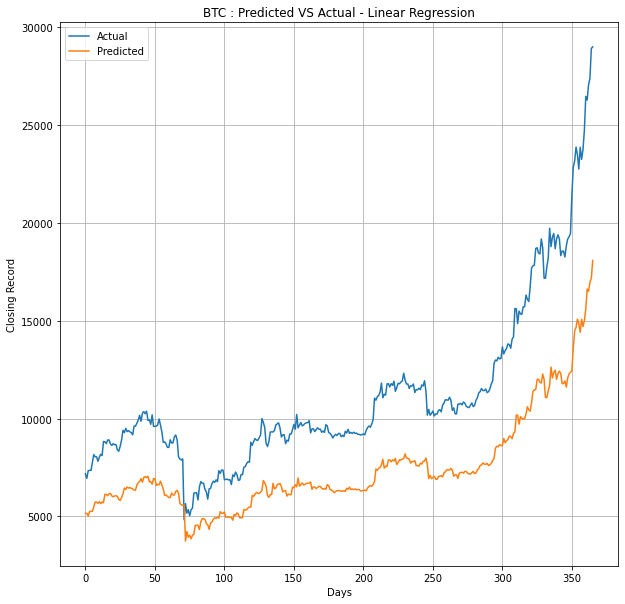

In [65]:
target_df = pd.DataFrame()
target_df["Actual"] = df_test_BTC['Close']
target_df["Predicted"] = y_pred

ax = target_df.plot(kind = 'line',
                grid = True,
                legend = True,
                figsize = (10, 10),
                title = "BTC : Predicted VS Actual - Linear Regression")
ax.set_xlabel("Days")
ax.set_ylabel("Closing Record")